In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from glob import glob

import os
from xrdc import source_separation as sep

In [2]:
plt.rcParams["figure.figsize"]=(15, 10)

In [3]:
scanfiles = sorted(glob("diffractionhistograms/same*"), key = lambda s: int(s.split('_')[1].split('.')[0]))

In [4]:
patterns = np.vstack([(pd.read_csv(path).T)[1] for path in scanfiles])

# raw

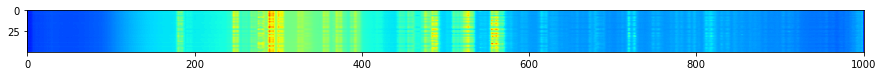

In [5]:
plt.imshow((1 + patterns), cmap = 'jet')

In [24]:
cutoff = .08

In [25]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, threshold = 25, cutoff = cutoff)

# background

In [8]:
background = sep.get_background(slow_T, threshold = 25, smooth_q = 1.7, method = 'simple')

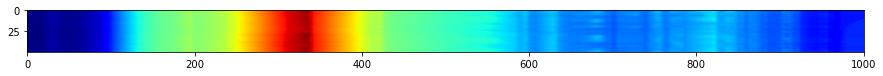

In [75]:
plt.imshow(background, cmap = 'jet')

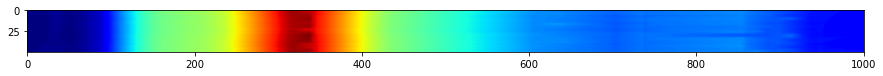

In [96]:
plt.imshow(slow_q, cmap = 'jet')

# background subtracted

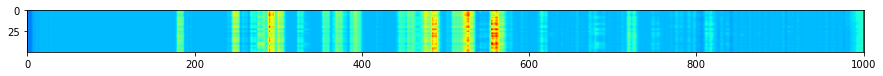

In [71]:
plt.imshow((1 + fast_q - fast_q.min()), cmap = 'jet')

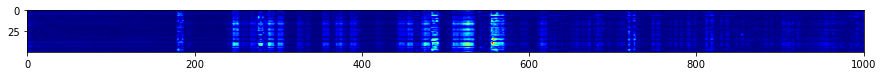

In [95]:
plt.imshow(np.log(1 + np.abs(fast_T / patterns)), cmap = 'jet')

Cutoff parameter is important!

In [152]:
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

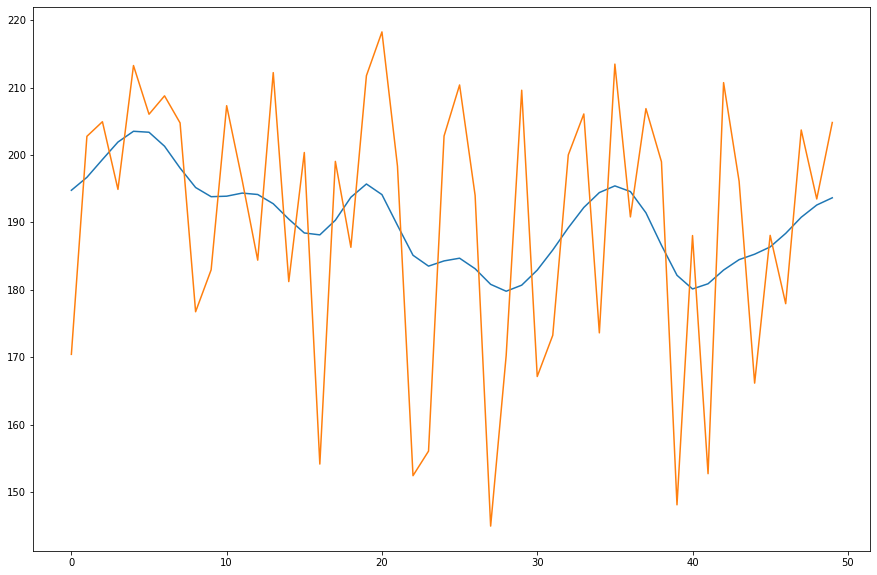

In [9]:
j = 531
plt.plot((slow_T).T[j])
plt.plot((patterns).T[j])
# plt.plot(fast_T.T[100])

<IPython.core.display.Javascript object>


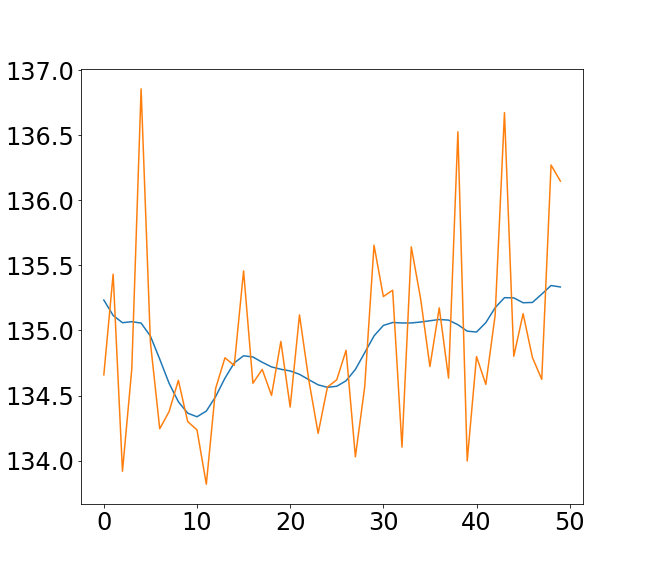

In [173]:
j = 150
plt.plot((slow_T).T[j])
plt.plot((patterns).T[j])
# plt.plot(fast_T.T[100])

In [10]:
%matplotlib notebook

In [11]:
from importlib import reload
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

In [13]:
%matplotlib inline
sep.iplot_rows(patterns, slow_q, fast_q, label1 = 'raw', label2 = 'background')

interactive(children=(IntSlider(value=25, description='i', max=50), Output(layout=Layout(height='550px'))), _d…

<IPython.core.display.Javascript object>


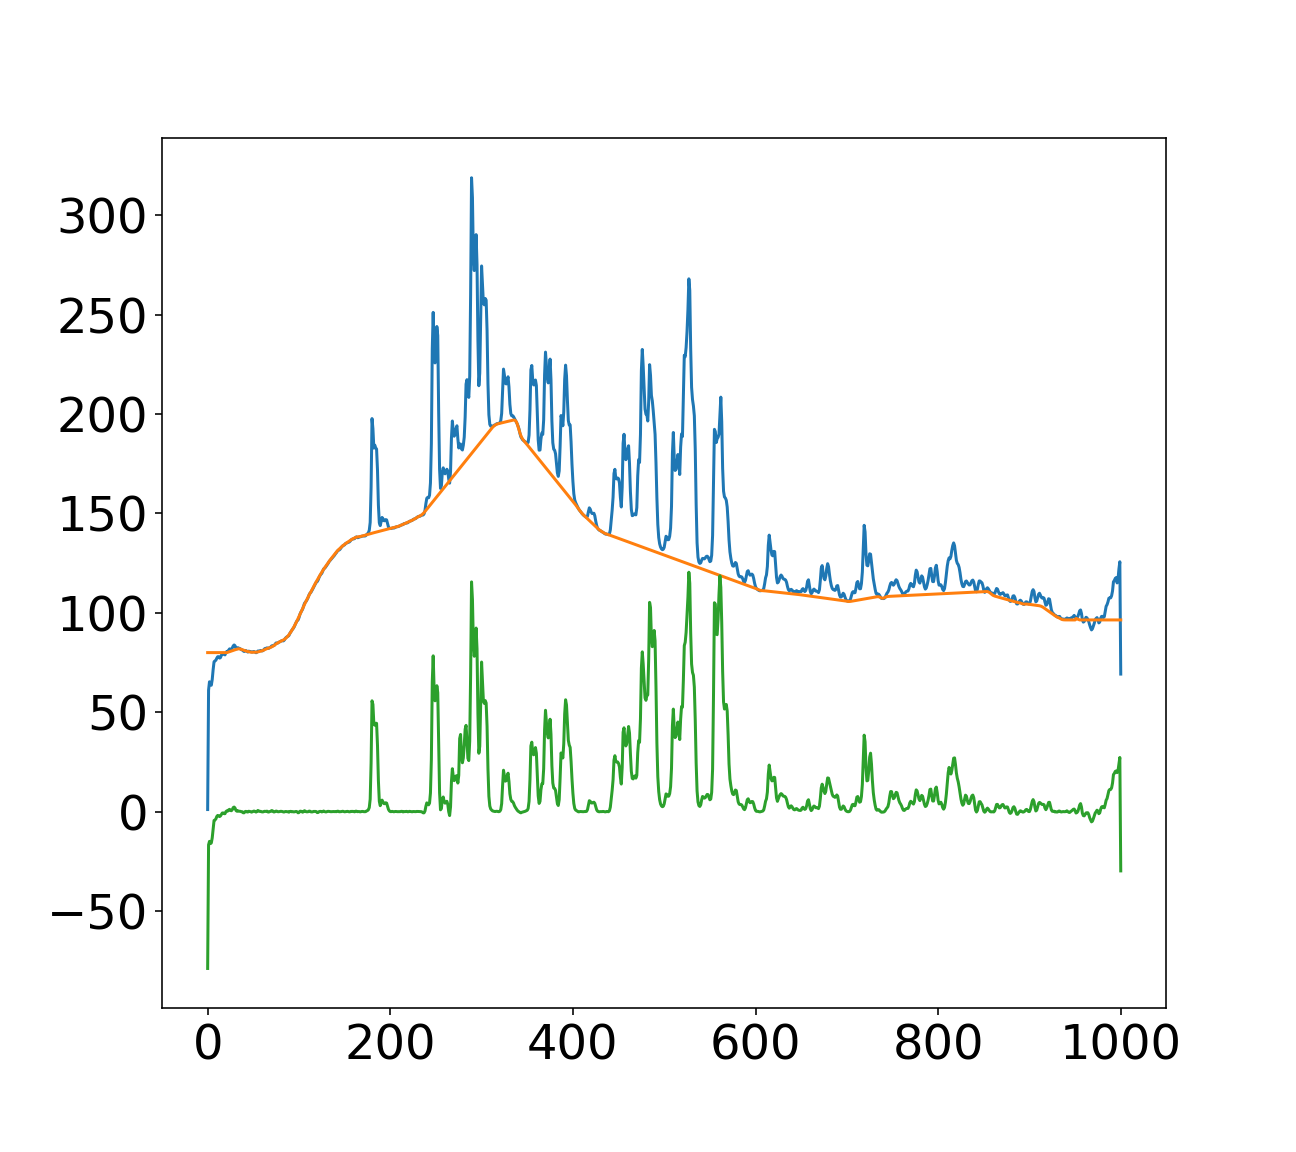

In [118]:
%matplotlib notebook
i = 10
x = np.arange(len(patterns[i]))
plt.plot(x, patterns[i])
#plt.plot(background[0])
plt.plot(x, slow_q[i])
plt.plot(x, fast_q[i])

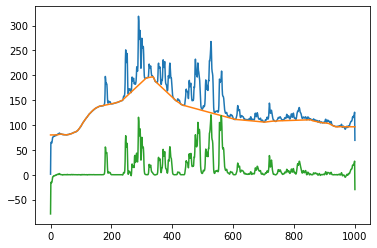

In [15]:
%matplotlib inline
i = 10
x = np.arange(len(patterns[i]))
plt.plot(x, patterns[i])
#plt.plot(background[0])
plt.plot(x, slow_q[i])
plt.plot(x, fast_q[i])

In [16]:
def peakratio(arr, xmin1, xmax1, xmin2, xmax2):
    return arr[xmin2: xmax2].sum() / arr[xmin1: xmax1].sum()

from sklearn.utils import resample

def boot(ratios, N = 200):
    boot = np.array( [resample(ratios, replace = True).mean() for _ in range(N)])
    return boot.mean(), boot.std(), boot.std() / boot.mean()

def boot_std(arr, N = 200):
    return boot(arr, N)[1]

Define peak boundaries for sample species concentration ratio calculation:

In [17]:
a, b, c, d = 318, 343, 703, 739

In [18]:
%matplotlib inline

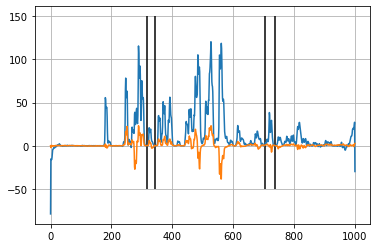

In [19]:
plt.plot(fast_q[i])
plt.plot(fast_T[i])
plt.vlines([a, b, c, d], -50, 150, color = 'k')
plt.grid()

In [ ]:
mean([x1, x2, x3, x4, x5])


## Peak ratio stats with bootstrapping

In [20]:
ratios = np.array([peakratio(row, a, b, c, d) for row in fast_q])
boot_ratio, boot_ratio_std, boot_ratio_std_rel = boot(ratios)
print("peak ratio (bootstrap mean),", boot_ratio)
print("peak ratio error (bootstrap standard deviation of the mean):", boot_ratio_std)
print("peak ratio relative error:", boot_ratio_std_rel)

peak ratio (bootstrap mean), 1.8215229716836716
peak ratio error (bootstrap standard deviation of the mean): 0.050879326819240914
peak ratio relative error: 0.027932300393780977


## Compare to no background subtraction:

In [21]:
ratios = np.array([peakratio(row, a, b, c, d) for row in patterns])
boot_ratio, boot_ratio_std, boot_ratio_std_rel = boot(ratios)
print("peak + bg ratio (bootstrap mean),", boot_ratio)
print("peak + bg ratio error (bootstrap standard deviation of the mean):", boot_ratio_std)
print("peak + bg ratio relative error:", boot_ratio_std_rel)

peak + bg ratio (bootstrap mean), 0.8280667816496476
peak + bg ratio error (bootstrap standard deviation of the mean): 0.0016762450315824648
peak + bg ratio relative error: 0.002024287254034154


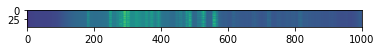

In [26]:
plt.imshow(patterns)

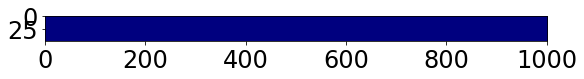

In [31]:
bgmask = sep.get_bgmask(patterns, 100, cutoff = cutoff)
plt.imshow(bgmask, cmap = 'jet')

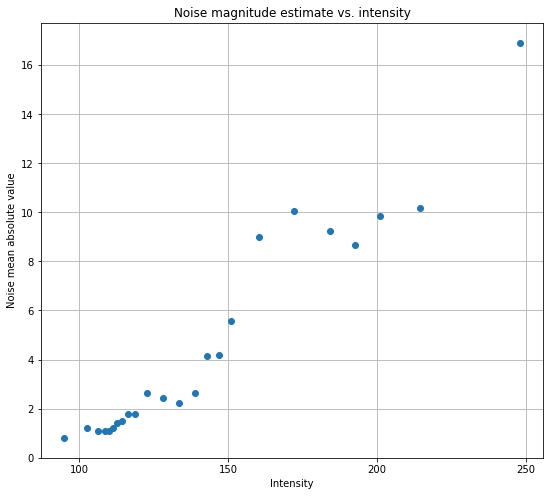

In [32]:
%matplotlib inline

nsplit = 25
fast_T_trunc = fast_T[:, 50: -50]
intensities = (patterns * bgmask)[:, 50: -50].ravel()

# intensities = patterns[:20, 50:400].ravel()
# intensities = slow_T.T[:20, 50:400].ravel()
# intensities = slow_T.T.ravel()

# absolute deviation
noise = np.abs(fast_T_trunc.ravel())
# noise = fast_T.T[:20, 50:400].ravel()
# noise = fast_T.T.ravel()

sorter = np.argsort(intensities)

splitsort = np.split(sorter, nsplit)
splitintensity = np.array([(intensities[idxs]).ravel().mean() for idxs in splitsort])

# mean absolute values of the high-T noise
splitmean = np.array([(noise[idxs]).mean() for idxs in splitsort])
split_noise_abs_std = np.array([(noise[idxs]).std() for idxs in splitsort])

splitstd = np.array([(fast_T_trunc.ravel())[idxs].std() for idxs in splitsort])

# logsplitintensity, logsplitstd = np.log10(splitintensity), np.log10(splitstd)

plt.rcParams["figure.figsize"]=(9, 8)
#plt.plot(splitintensity, splitmean, 'o')

plt.plot(splitintensity[splitintensity > 0][1:], splitstd[splitintensity > 0][1:], 'o')
#plt.plot(splitintensity[splitintensity > 0][1:], split_noise_abs_std[splitintensity > 0][1:], 'o')

# plt.xlim(1000, None)
# # plt.ylim(1, None)
# #plt.plot(splitstd, 'o')
# # plt.semilogx()
# # plt.semilogy()
plt.xlabel('Intensity')
plt.ylabel('Noise mean absolute value')
plt.title("Noise magnitude estimate vs. intensity")
matplotlib.rcParams.update({'font.size': 24})

plt.grid()

In [71]:
arr = noise
aggregator = lambda arr, f: np.array([(f(arr[idxs]).ravel()) for idxs in splitsort])
medians = aggregator(arr, np.median)

p25 = aggregator(arr, lambda a: np.percentile(a, 25)).ravel()
p75 = aggregator(arr, lambda a: np.percentile(a, 75)).ravel()

yerr_above = p75 - medians
yerr_below = medians - p25

ysplits = aggregator(arr, lambda a: a)

[]

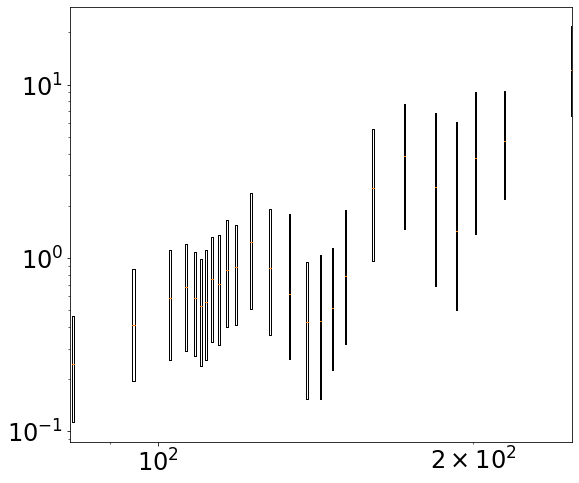

In [115]:
plt.boxplot(list(ysplits), showfliers = False, whis = 0, positions = splitintensity);
plt.semilogx()
plt.semilogy()

In [110]:
splitintensity

array([ 83.05093369,  94.82414217, 102.76938726, 106.47822486,
       108.65936044, 110.09685747, 111.32038475, 112.73099817,
       114.52351202, 116.41531405, 118.80486037, 122.78221154,
       127.99547379, 133.56705786, 138.75584137, 143.07478583,
       146.89172875, 151.03787254, 160.54078243, 171.99483554,
       184.18066073, 192.66456387, 201.10496246, 214.36851827,
       248.13933714])

In [101]:
plt.boxplot?

In [92]:
list(ysplits)

[array([0.56548745, 0.79160947, 0.56346869, ..., 0.55906243, 0.28608479,
        0.7512196 ]),
 array([0.08443539, 0.21715259, 1.03233417, ..., 0.40830121, 0.42894124,
        0.25910124]),
 array([0.7195097 , 1.01504359, 0.34594591, ..., 0.27193932, 0.19960143,
        0.24923975]),
 array([1.08243609, 0.18848279, 0.24688713, ..., 2.14029363, 0.3342221 ,
        1.14238408]),
 array([1.85757403, 0.94016531, 0.04155209, ..., 0.43516189, 0.5711685 ,
        1.21509258]),
 array([0.07359873, 3.63159859, 1.17688425, ..., 0.39898139, 0.56755676,
        0.85072834]),
 array([1.24714352, 1.7965557 , 0.40746048, ..., 1.23159998, 0.31393509,
        1.13085988]),
 array([0.89462255, 0.94845065, 2.00146981, ..., 1.29268372, 0.47701402,
        0.22208924]),
 array([0.37638757, 2.10587581, 1.92143416, ..., 2.93878005, 1.10500304,
        1.24983289]),
 array([1.49733024, 0.3096998 , 1.54406929, ..., 1.47209584, 1.14568941,
        0.83164557]),
 array([1.89384136, 0.34966451, 1.49116979, ..., 4

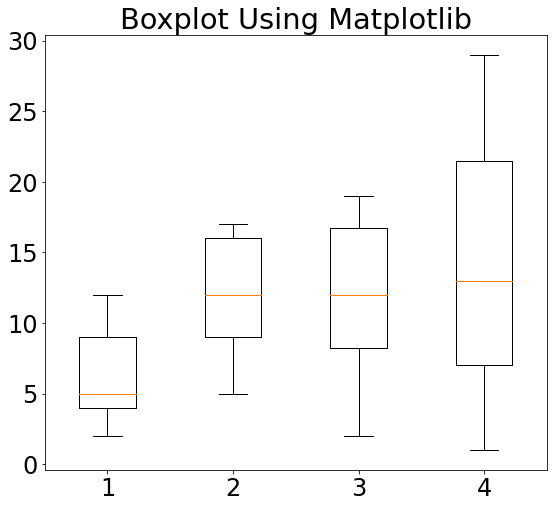

In [90]:
import numpy as np
import matplotlib.pyplot as plt 

np.random.seed(100) 
  
data_a =np.random.randint(2,15, size=15) 
data_b =np.random.randint(5,18, size=20) 
data_c =np.random.randint(2,20, size=30) 
data_d =np.random.randint(1,30, size=40) 

data_2d=[data_a,data_b,data_c,data_d]

plt.boxplot(data_2d)
plt.title("Boxplot Using Matplotlib")
plt.show()

In [54]:
intensities.min()

79.20559692382812

In [43]:
splitintensity

array([ 83.05093369,  94.82414217, 102.76938726, 106.47822486,
       108.65936044, 110.09685747, 111.32038475, 112.73099817,
       114.52351202, 116.41531405, 118.80486037, 122.78221154,
       127.99547379, 133.56705786, 138.75584137, 143.07478583,
       146.89172875, 151.03787254, 160.54078243, 171.99483554,
       184.18066073, 192.66456387, 201.10496246, 214.36851827,
       248.13933714])

In [ ]:
plt.plot(splitintensity[splitintensity > 0][1:], splitstd[splitintensity > 0][1:], 'o')

In [33]:
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

In [37]:
noise

array([0.40108939, 0.26192427, 0.32467645, ..., 1.0437201 , 1.05773437,
       1.00720168])

In [119]:
from numpy import random